In [10]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score

In [11]:
# Load and preprocess the data
df = pd.read_csv('leaves.csv' , header=None)
print(len(df))

print(len(set(df[0])))
print(set(df[0]))

df

340
30
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,0.114880,0.208610,0.041703,0.013344,0.000820,2.02810
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,0.141220,0.218300,0.045488,0.012002,0.001515,2.40590
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,0.097663,0.207030,0.041101,0.016123,0.000453,1.69350
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,0.050389,0.135850,0.018121,0.006190,0.000265,1.15260


In [12]:
def load_images_from_folders(root_folder):
    images = []
    image_names = []
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    images.append(image)
                    # Extract the number after 'EX' from filename like 'iPAD2_C04_EX08.JPG'
                    image_number = image_name.split('_')[-1].split('.')[0][2:]  # Assuming 'EX08' part is the index
                    image_number = image_number.zfill(2)  # Ensure the number has two digits
                    image_names.append(image_number)  
    return images, image_names

def preprocess_image(image):
    # Gaussian Blur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)
    return edges

def extract_features(image):
    features = {}
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # area and perimeter
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        features['area'] = cv2.contourArea(cnt)
        features['perimeter'] = cv2.arcLength(cnt, True)
    else:
        features['area'] = 0
        features['perimeter'] = 0
    
    features['mean_intensity'] = np.mean(image)
    features['std_intensity'] = np.std(image)

    # Hough Transform
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    if lines is not None:
        features['num_hough_lines'] = len(lines)
        features['total_hough_length'] = sum(
            np.sqrt((line[0][2] - line[0][0]) ** 2 + (line[0][3] - line[0][1]) ** 2) for line in lines)
    else:
        features['num_hough_lines'] = 0
        features['total_hough_length'] = 0

    return features

root_folder = './leaves'
images, image_names = load_images_from_folders(root_folder)

preprocessed_images = [preprocess_image(image) for image in images]

features_list = [extract_features(image) for image in preprocessed_images]

df_features = pd.DataFrame(features_list)

for column in df_features.columns:
    df[column] = df_features[column]

df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,area,perimeter,mean_intensity,std_intensity,num_hough_lines,total_hough_length
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,0.016108,0.005232,0.000275,1.17560,21.0,105.053822,0.196267,7.071751,0,0.0
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,0.008119,0.002708,0.000075,0.69659,94.5,716.222429,0.361914,9.599849,0,0.0
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,0.003289,0.000921,0.000038,0.44348,85.5,725.251867,0.260091,8.139754,0,0.0
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,0.004271,0.001154,0.000066,0.58785,111.0,996.974739,0.307313,8.847060,0,0.0
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,0.002051,0.000560,0.000024,0.34214,59.5,733.026472,0.226150,7.590596,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,0.041703,0.013344,0.000820,2.02810,44.5,298.575682,1.037413,16.231578,0,0.0
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,0.045488,0.012002,0.001515,2.40590,35.0,166.793936,0.335720,9.246406,0,0.0
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,0.041101,0.016123,0.000453,1.69350,29.5,390.291411,0.270052,8.293995,0,0.0
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,0.018121,0.006190,0.000265,1.15260,83.5,799.737149,0.533464,11.651121,0,0.0


In [13]:
df = df.drop_duplicates(ignore_index=True)
df = df.drop(columns=[1])

print(len(df))
df

340


,0,2,3,4,5,6,7,8,9,10,...,12,13,14,15,area,perimeter,mean_intensity,std_intensity,num_hough_lines,total_hough_length
0,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,0.047790,...,0.016108,0.005232,0.000275,1.17560,21.0,105.053822,0.196267,7.071751,0,0.0
1,1,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,0.024160,...,0.008119,0.002708,0.000075,0.69659,94.5,716.222429,0.361914,9.599849,0,0.0
2,1,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,0.011897,...,0.003289,0.000921,0.000038,0.44348,85.5,725.251867,0.260091,8.139754,0,0.0
3,1,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,0.015950,...,0.004271,0.001154,0.000066,0.58785,111.0,996.974739,0.307313,8.847060,0,0.0
4,1,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,0.007938,...,0.002051,0.000560,0.000024,0.34214,59.5,733.026472,0.226150,7.590596,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,0.114880,...,0.041703,0.013344,0.000820,2.02810,44.5,298.575682,1.037413,16.231578,0,0.0
336,36,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,0.141220,...,0.045488,0.012002,0.001515,2.40590,35.0,166.793936,0.335720,9.246406,0,0.0
337,36,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,0.097663,...,0.041101,0.016123,0.000453,1.69350,29.5,390.291411,0.270052,8.293995,0,0.0
338,36,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,0.050389,...,0.018121,0.006190,0.000265,1.15260,83.5,799.737149,0.533464,11.651121,0,0.0


In [14]:
def report_na(df):
    na_counts = df.isna().sum()
    total_na = df.isna().sum().sum()
    
    # print("Number of NaN values in each column:")
    # print(na_counts)
    print("\nTotal number of NaN values in the DataFrame:", total_na)

    return na_counts, total_na


report_na(df)


Total number of NaN values in the DataFrame: 0


(0                     0
 2                     0
 3                     0
 4                     0
 5                     0
 6                     0
 7                     0
 8                     0
 9                     0
 10                    0
 11                    0
 12                    0
 13                    0
 14                    0
 15                    0
 area                  0
 perimeter             0
 mean_intensity        0
 std_intensity         0
 num_hough_lines       0
 total_hough_length    0
 dtype: int64,
 0)

In [15]:
Y = df[0]
X = df.drop(columns=[0])
X
X.columns = X.columns.astype(str)

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# Apply Scaler
# Scaler = PCA(.95)
# Scaler = MinMaxScaler()
Scaler = StandardScaler()


# Fit and transform the training data
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [17]:
# Train the model
# model = OneVsRestClassifier(SVC())
model = RandomForestClassifier()
model.fit(X_train, y_train)

Y_pred = model.predict(X_test)

class_report = classification_report(y_test, Y_pred, zero_division=1)

print("\nClassification Report:")
print(class_report)

# No feature extraction - RandomForestClassifier 
#     accuracy                           0.81        85
#    macro avg       0.84      0.83      0.82        85
# weighted avg       0.84      0.81      0.81        85
# ------------------------------------------------------
# feature extraction - RandomForestClassifier 
#     accuracy                           0.85        85
#    macro avg       0.86      0.86      0.84        85
# weighted avg       0.89      0.85      0.85        85
# ------------------------------------------------------
# No feature extraction - OneVsRestClassifier(SVC()) 
#     accuracy                           0.72        85
#    macro avg       0.72      0.75      0.67        85
# weighted avg       0.80      0.72      0.73        85
# ------------------------------------------------------
# feature extraction - OneVsRestClassifier(SVC()) 
#     accuracy                           0.76        85
#    macro avg       0.76      0.81      0.70        85
# weighted avg       0.85      0.76      0.76        85
# ------------------------------------------------------


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.00      1.00      0.00         0
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      0.33      0.50         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       0.67      1.00      0.80         4
          12       0.43      1.00      0.60         3
          13       1.00      1.00      1.00         2
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00         3
          22       0.00      0.00      0.00         3
          23       1.00      0.67      0.80         3
   

Model: KMeans, Silhouette Score: 0.20803160592382333
Model: KMeans, NMI Score: 0.6674961804105005


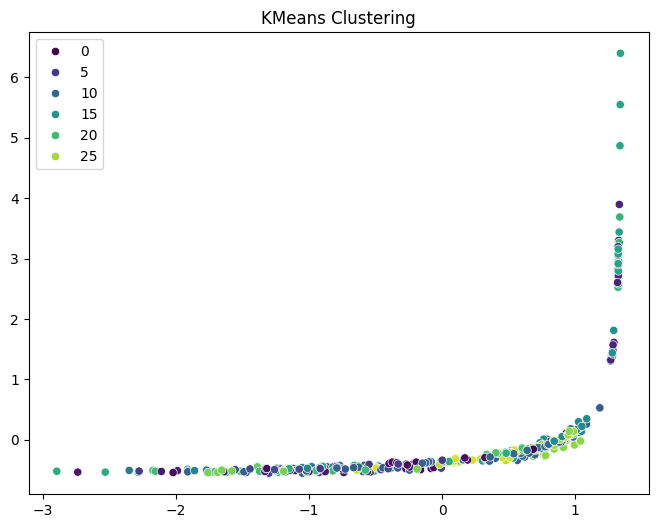

Model: Agglomerative, Silhouette Score: 0.21512905770494792
Model: Agglomerative, NMI Score: 0.693348996413575


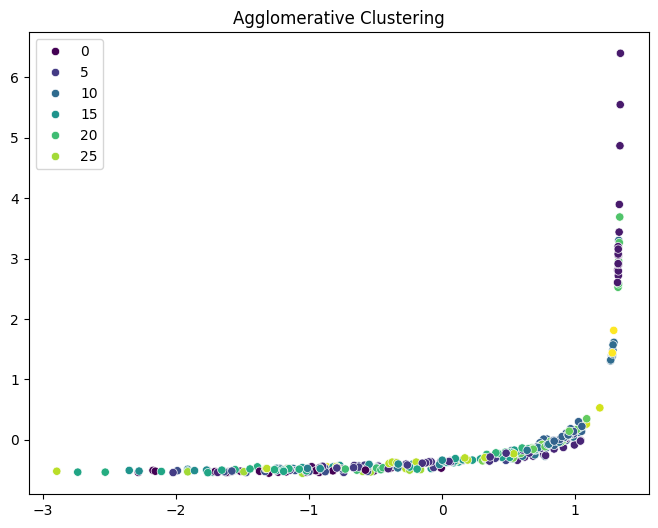

In [18]:
#models:
kmeans = KMeans(n_clusters=30)
agglo = AgglomerativeClustering(n_clusters=30)
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# models = [('KMeans', kmeans), ('Agglomerative', agglo), ('DBSCAN', dbscan)]

models = [('KMeans', kmeans), ('Agglomerative', agglo)]

# Apply Scaler
# Scaler = PCA(.95)
# Scaler = MinMaxScaler()
Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X)

for name, model in models:
    model.fit(X_scaled)
    if hasattr(model, 'labels_'):
        labels = model.labels_
    else:
        labels = model.predict(X_scaled)
    # silhouette
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f'Model: {name}, Silhouette Score: {silhouette_avg}')

    # NMI
    nmi_score = normalized_mutual_info_score(Y, labels)
    print(f'Model: {name}, NMI Score: {nmi_score}')
    
    # result
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='viridis')
    plt.title(f'{name} Clustering')
    plt.show()
# ------------------------------------------------------
# Model: KMeans,          Silhouette: 0.3970936069417555
# Model: KMeans,          NMI Score:  0.6637982826872195
# Model: Agglomerative,   Silhouette  0.31512905770494792
# Model: Agglomerative,   NMI Score:  0.693348996413575